# [SWCON253] Machine Learning
Teaching Assistant: Hyunmin Ban (hmban1996@khu.ac.kr)

Professor: Hui Yong Kim (hykim.v@khu.ac.kr)

---

# P2:  Deep Learning Framwork: Pytorch를 이용하여 MLP 구현 (10점)

### 학습목표
- pytorch를 사용하여 구현된 MLP 구조를 이해하고 수정할수 있다.
- Fashinon-MNIST 문제를 스스로 해결하면서 딥러닝 학습과정을 이해하고 하이퍼파라미터를 튜닝을 할 수 있다.

### 실습내용
pytorch를 사용하여 구현 되어 있는 MLP를 통해 Fashion-MNIST 데이터셋을 분류하는 classfier를 학습합니다.

실습은 다음 순서로 진행됩니다.
- 1) Fashon-MNIST 데이터셋 설명
- 2) Data loading
- 3) Multilayer Perceptron Model
- 4) Training
- 5) Evaluation
- 6) Discussion

아래 코드에는 2개의 퍼셉트론은 이용한 MLP 모델이 정의 되어 있습니다.
실습을 시작하기전에 이 노트북 파일을 읽고 모든 셀을 실행해하여 올바르게 작동하는지 확인하세요.<br>
이후에 아키텍쳐를 마음껏 변경하여 최고의 성능이 나오도록 수정해 보세요.

다음은 변경 가능한 부분입니다.
- activation 함수 (logistic sigmoid, tanh, relu, leaky relu, ...)
- learning rate
- hidden layers 갯수
- epochs
- minibatch size

그러나 다음 사항은 변경하지 마세요.
- 가중치 초기화 방법
- 랜덤시드
- 최적화 방법, 학습 방법

layer를 추가하여 2개 이상의 hidden layer를 구성할 수 있게 구현하세요. <br>

수정가능한 셀은 아래 주석으로 확실하게 하이라이트되어 표시되어 있습니다.

```
############################################################
# 변경 가능한 셀
############################################################
```

### 점수
**Test set 기준**

- 정확도 85% 이상 2점
- 정확도 86% 이상 4점
- 정확도 87% 이상 6점
- 정확도 88% 이상 8점

**구현**
- Layer 수 2개 이상으로 구현: 2점

`.ipynb 파일과 함께 .html 파일 (File -> export as -> HTML)도 함께 제출하세요. 하나만 제출할시 감점이 있습니다.`

In [1]:
import torch
import os
import numpy as np
import time
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
# Document: https://pytorch.org/docs/stable/nn.functional.html
import matplotlib.pyplot as plt
# Document: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
%matplotlib inline

In [2]:
# 이 부분은 절대 변경하지 마세요.

RANDOM_SEED = 123
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 1) Dataset 설명

이 데이터셋은 기존의 MNIST와 비슷하게 10개의 클래스로 이루어진 데이터셋입니다. 또한 흑백의 28x28크기, 60k개의 학습용 이미지와 10k개의 테스트용 이미지로 구성 되어 있는것과 같이 MNIST와 대부분 비슷한 구조로 이뤄져 있습니다. 

아래는 데이터셋의 샘플 이미지 입니다.

![](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

출처: https://github.com/zalandoresearch/fashion-mnist)



데이터셋의 10개의 클래스는 다음과 같습니다.


| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

## 2) Dataset Loader

In [3]:
import torch
from PIL import Image
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import os

In [4]:
# Train 데이터 로딩시 이미지 데이터 전처리를 Transforms를 통해 할 수 있습니다.
# ToTensor는 PIL 형태의 이미지나 ndarray 를 PyTorch 가 이해할 수 있는 tensor 자료형으로 바꾸어 주는 역할을 하며
# Random Flip, Random Crop 등을 사용하여 Data augmentation을 수행하고 이를 통해 좋은 성능을 얻을 수 있습니다.
# 하지만, 이번 실습에서는 사용하지 않습니다.
# Document: https://pytorch.org/vision/stable/transforms.html
custom_train_transform = transforms.Compose([  
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [5]:
# Test 데이터 로딩시 데이터 Transform
# Testset의 Trainsform은 Training set 과 다르게 랜덤하게 변경되면 안됩니다.
# 이번 실습에서는 사용하지 않습니다.
custom_test_transform = transforms.Compose([
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [6]:
############################################################
# 변경 가능한 셀
############################################################

BATCH_SIZE = 128 # 60000을 사용하면 Full-Batch 학습

In [7]:
train_dataset = FashionMNIST(".", train=True, download=True, transform=custom_train_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          drop_last=True,
                          num_workers=2)


test_dataset = FashionMNIST(".", train=False, download=True, transform=custom_test_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=2)

아래 셀은 데이터셋이 잘 Load 되었는지 확인하는 테스트용 코드입니다.

In [8]:
num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        print('break minibatch for-loop')
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
break minibatch for-loop


RuntimeError: DataLoader worker (pid(s) 8260) exited unexpectedly

## 3) Multilayer Perceptron Model

아래 셀은 MLP모델을 정의하는 부분입니다. 이 과제에서 메인 부분입니다.<br>
Hidden layer이 2개가 되도록 변경하세요. 필요에 따라 3개 이상으로 늘려도 됩니다.

In [23]:
############################################################
# 변경 가능한 셀
############################################################

class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_hidden_2, num_classes):
        super(MLP, self).__init__()
        
        self.num_classes = num_classes
        
        ### 레이어 수 추가
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2)
        self.linear_out = torch.nn.Linear(num_hidden_2, num_classes)
        
    def forward(self, x):
        
        ### activation 함수 변경 가능
        ### 레이어간의 연결 추가, 변경
        out = self.linear_1(x)
        out = F.relu(out)
        out = self.linear_2(out)
        out = F.relu(out)

        
        # <your code> to set the layer and the activation function
        
        logits = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

    
#################################
### Model 초기화
#################################

# random seed는 무작위 가중치 초기화가 항상 같도록 해줍니다.
# 초기화된 가중치에 따라 같은 네트워크도 서로 다른 성능을 낼 수 있어서 
# 실제 사용시에는 좋은 성능을 얻기 위해 여러가지 무작위 가중치를 시도해 볼 수 있습니다.
# 그러나 이 과제에서는 변경하지 않습니다.
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

### num_hidden_1, num_hidden_2 변경 가능, 
### 레이어를 더 추가하고 싶다면 이부분을 알맞게 수정하세요.
model = MLP(num_features=28*28,
            num_hidden_1=128,
            num_hidden_2=64,
            num_classes=10)

model = model.to(DEVICE)

## 4) Training

In [24]:
############################################################
# 변경 가능한 셀
############################################################

### Optimizer는 가중치를 업데이트하는 방법을 바꾸어 더 빠르게 좋은 성능을 낼 수 있도록합니다.
### 이 과제에서는 optimizer를 변경하지 않습니다. 
### 그러나 Learning Rate(lr)는 변경이 가능합니다.
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
############################################################

In [25]:
############################################################
# 변경 가능한 셀
############################################################

NUM_EPOCHS = 3 # 변경 가능
############################################################

In [26]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples
    

start_time = time.time()
train_acc_lst, test_acc_lst = [], []
train_loss_lst, test_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 40:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, device=DEVICE)
        train_acc_lst.append(train_acc)
        test_acc_lst.append(test_acc)
        train_loss_lst.append(train_loss)
        test_loss_lst.append(test_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Test Acc.: {test_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

RuntimeError: DataLoader worker (pid(s) 16872) exited unexpectedly

## 5) Evaluation

테스트 데이터와 학습 데이터의 Loss변화를 확인합니다.

In [ ]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), test_loss_lst, label='Test loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

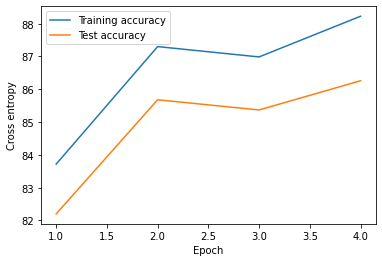

In [22]:
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), test_acc_lst, label='Test accuracy')
plt.legend(loc='upper left')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

In [23]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 86.26%


### 6) Discussion

**1) 학습, 테스트 정확도는 얼마인가요? (위 숫자를 복사하세요.)**

- Training:  ???%
- Test ???%

**2) overfitting을 경험했나요? 만약 그랬다면 왜 그랬을지 적어보고, overfitting을 방지하기위한 간단한 방법은 무엇일까요?**

[제안하는 방법 적기]

예를 들면, 

- batch size를 256으로 변경
- 두개의 hidden layers의 activation을 relu로 변경
- learning rate를 0.2로 변경

**3) 만약 hidden layer 수가 늘어나면(3개 이상) 얻을 수 있는 장/단점은 무엇일까요?**

[답변작성]

**4) 구현하면서 수정한 부분에 대해 작성하여 수정한 이유 및 성능향상이 생긴 이유에 대해 답해보세요.**

[답변작성]